In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.insert(1, '../utils/')

from utils.deafrica_datahandling import load_ard, mostcommon_crs
from utils.deafrica_plotting import rgb
from utils.deafrica_bandindices import calculate_indices
from odc.ui import with_ui_cbk

In [2]:
dc = datacube.Datacube(app='Sentinel-2')

In [3]:
lat, lon = 42.86, -2.6
buffer = 0.125

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('2022-01-01', '2022-01-31'),
    'resolution': (-30, 30)
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='s2_l2a', query=query)
print(output_crs)

# Load available data from Sentinel-2 and filter to retain only times
# with at least 90% good data
ds = load_ard(dc=dc, 
              products=['s2_l2a'],
              min_gooddata=0.9, 
              measurements=['red', 'green', 'blue', 'swir_1', 'swir_2', 'nir', 'nir_2'],
              output_crs=output_crs,
              progress_cbk=with_ui_cbk(),
              **query)

epsg:32630


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 6 out of 13 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Loading 6 time steps


In [4]:
print(ds)

<xarray.Dataset>
Dimensions:      (time: 6, x: 686, y: 929)
Coordinates:
  * x            (x) float64 5.224e+05 5.225e+05 5.225e+05 ... 5.43e+05 5.43e+05
    spatial_ref  int32 32630
  * y            (y) float64 4.759e+06 4.759e+06 ... 4.731e+06 4.731e+06
  * time         (time) datetime64[ns] 2022-01-01T11:19:11 ... 2022-01-26T11:...
Data variables:
    red          (time, y, x) float32 692.0 515.0 550.0 638.0 ... nan nan nan
    green        (time, y, x) float32 578.0 502.0 581.0 610.0 ... nan nan nan
    blue         (time, y, x) float32 427.0 301.0 299.0 342.0 ... nan nan nan
    swir_1       (time, y, x) float32 2038.0 2009.0 2282.0 ... nan nan nan
    swir_2       (time, y, x) float32 1362.0 1186.0 1352.0 ... nan nan nan
    nir          (time, y, x) float32 1636.0 2112.0 2836.0 ... nan nan nan
    nir_2        (time, y, x) float32 1758.0 2159.0 3048.0 ... nan nan nan
Attributes:
    crs:           epsg:32630
    grid_mapping:  spatial_ref


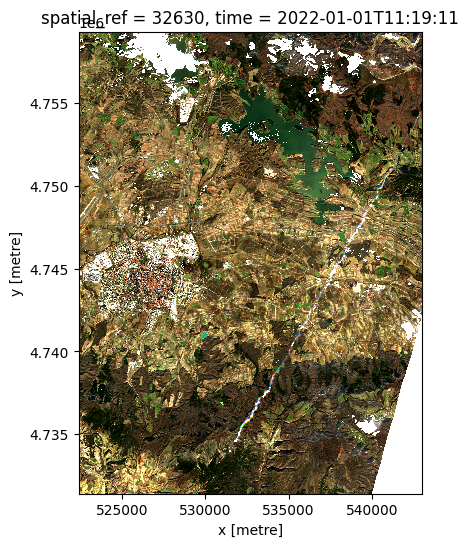

In [8]:
# Plot as an RGB image
rgb(ds, index=[0])

In [16]:
# Calculate NDVI using the formula above
# Calculate NDVI using the formula above
ds['NDVI_manual'] = (ds.nir - ds.red) / (ds.nir + ds.red)

# Plot the results for one time step to see what they look like:
first_timestep = ds.NDVI_manual.isel(time=0)

print(first_timestep)

<xarray.DataArray 'NDVI_manual' (y: 929, x: 686)>
array([[0.4054983 , 0.6079178 , 0.6751329 , ..., 0.44284242, 0.3951557 ,
        0.46110484],
       [0.3832    , 0.5123457 , 0.57793766, ..., 0.48967993, 0.4270776 ,
        0.36448154],
       [0.61904764, 0.42857143, 0.5505618 , ..., 0.5249473 , 0.54533845,
        0.39798126],
       ...,
       [0.18972991, 0.17708333, 0.1628866 , ...,        nan,        nan,
               nan],
       [0.21672697, 0.17798519, 0.17310925, ...,        nan,        nan,
               nan],
       [0.5001726 , 0.31122088, 0.17555831, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * x            (x) float64 5.224e+05 5.225e+05 5.225e+05 ... 5.43e+05 5.43e+05
    spatial_ref  int32 32630
  * y            (y) float64 4.759e+06 4.759e+06 ... 4.731e+06 4.731e+06
    time         datetime64[ns] 2022-01-01T11:19:11


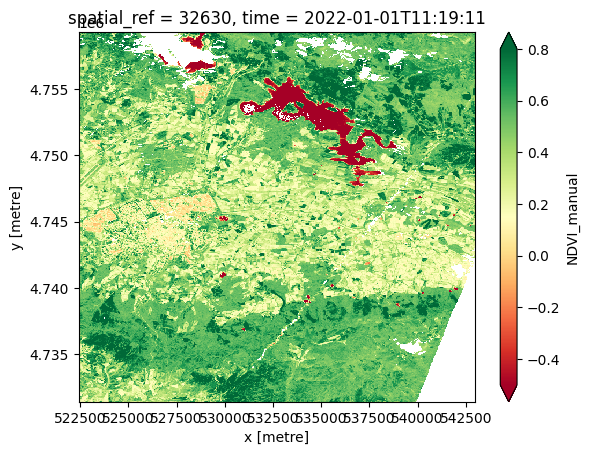

In [19]:
first_timestep.plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')

In [20]:
ds_multi = calculate_indices(ds, index=['NDVI', 'NDWI', 'MNDWI'], satellite_mission='s2')

print(ds_multi)

<xarray.Dataset>
Dimensions:      (time: 6, x: 686, y: 929)
Coordinates:
  * x            (x) float64 5.224e+05 5.225e+05 5.225e+05 ... 5.43e+05 5.43e+05
    spatial_ref  int32 32630
  * y            (y) float64 4.759e+06 4.759e+06 ... 4.731e+06 4.731e+06
  * time         (time) datetime64[ns] 2022-01-01T11:19:11 ... 2022-01-26T11:...
Data variables:
    red          (time, y, x) float32 692.0 515.0 550.0 638.0 ... nan nan nan
    green        (time, y, x) float32 578.0 502.0 581.0 610.0 ... nan nan nan
    blue         (time, y, x) float32 427.0 301.0 299.0 342.0 ... nan nan nan
    swir_1       (time, y, x) float32 2038.0 2009.0 2282.0 ... nan nan nan
    swir_2       (time, y, x) float32 1362.0 1186.0 1352.0 ... nan nan nan
    nir          (time, y, x) float32 1636.0 2112.0 2836.0 ... nan nan nan
    nir_2        (time, y, x) float32 1758.0 2159.0 3048.0 ... nan nan nan
    NDVI_manual  (time, y, x) float32 0.4054983 0.6079178 0.6751329 ... nan nan
    NDVI         (time, y, x) flo

In [24]:
# Plot the NDWI results 
ds_multi.NDWI['time']

<xarray.DataArray 'time' (time: 6)>
array(['2022-01-01T11:19:11.000000000', '2022-01-06T11:19:17.000000000',
       '2022-01-16T11:19:16.000000000', '2022-01-18T11:09:15.000000000',
       '2022-01-23T11:09:20.000000000', '2022-01-26T11:19:16.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 32630
  * time         (time) datetime64[ns] 2022-01-01T11:19:11 ... 2022-01-26T11:...
Attributes:
    units:    seconds since 1970-01-01 00:00:00